In [168]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import glob
import keras.backend as K
import os
import tqdm

K.clear_session() # 새로운 세션으로 시작

In [169]:
height = 64
width = 64

In [198]:
def img_read_resize(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (height, width))
    return img


In [199]:
def img_folder_read(img_label):
    img_files = []
    labels = []
    tfiles = glob.glob(f"{test_root_dir}/{img_label}/*")
    tfiles = sorted(tfiles)
    for t_img in tfiles:
        try:
            img_files.append(img_read_resize(t_img))
            labels.append(img_label)
        except:
            continue
    return img_files, labels

### 테스트 데이터

In [200]:
test_root_dir = "archive/test"
test_root_dir

'archive/test'

In [201]:
image_label = os.listdir(test_root_dir)
image_label.remove('.DS_Store')
image_label

['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

archive/test/happy/PrivateTest_10077120.jpg
archive/test/sad/PrivateTest_10247676.jpg
archive/test/fear/PrivateTest_10153550.jpg
archive/test/surprise/PrivateTest_10072988.jpg
archive/test/neutral/PrivateTest_10086748.jpg
archive/test/angry/PrivateTest_10131363.jpg
archive/test/disgust/PrivateTest_11895083.jpg


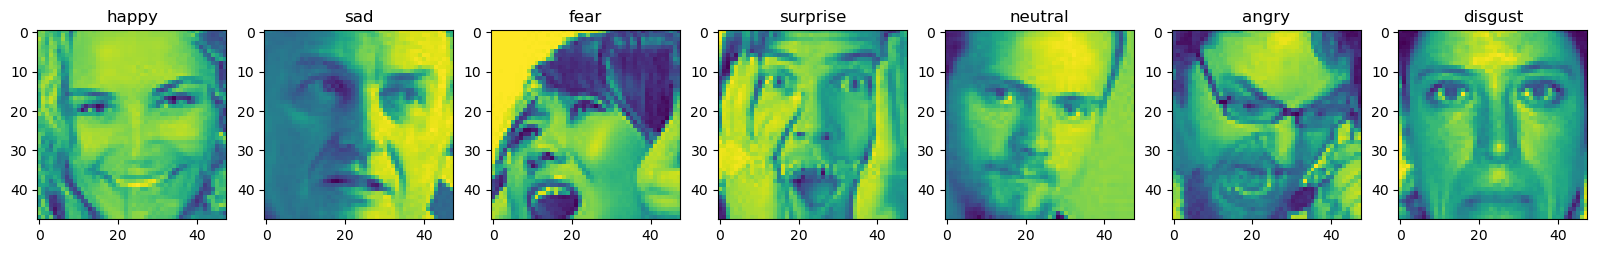

In [202]:
import glob

fig, axes = plt.subplots(nrows=1, ncols=len(image_label), figsize=(20, 5))

for i, img_label in enumerate(image_label):
    tfiles = glob.glob(f"{test_root_dir}/{img_label}/*")
    tfiles = sorted(tfiles)
    print(tfiles[0])    
    img = plt.imread(tfiles[0])
    axes[i].imshow(img)
    axes[i].set_title(img_label)

In [203]:
x_test_img = []
y_test_img = []
for img_label in tqdm.tqdm(image_label):
    x_temp, y_temp = img_folder_read(img_label)
    x_test_img.extend(x_temp)
    y_test_img.extend(y_temp)

len(x_test_img), len(y_test_img)

100%|██████████| 7/7 [00:00<00:00,  9.62it/s]


(7178, 7178)

Text(0.5, 1.0, 'happy')

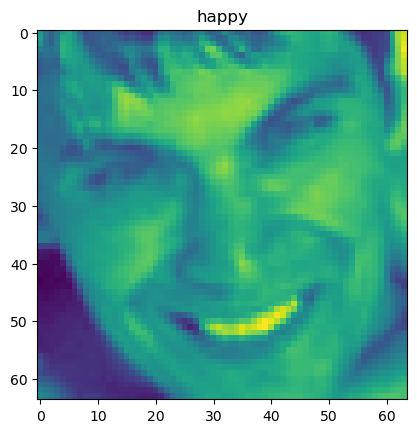

In [204]:
plt.imshow(x_test_img[1000])
plt.title(y_test_img[1000])

In [205]:
x_test_arr = np.array(x_test_img)
y_test_arr = np.array(y_test_img)

In [206]:
x_test = x_test_arr/255

In [207]:
x_test.shape

(7178, 64, 64)

### 트레인 데이터

In [180]:
data_generator = ImageDataGenerator(rescale = 1./255, validation_split=0.2)


In [181]:
train_generator = data_generator.flow_from_directory(
    directory = "archive/train",
    color_mode = 'grayscale',
    target_size = (height,width),
    batch_size = 64,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = False)

Found 22968 images belonging to 7 classes.


In [182]:
train_generator.class_indices


{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [183]:
val_generator = data_generator.flow_from_directory(
    directory = "archive/train",
    color_mode = 'grayscale',
    target_size =(height, width),
    class_mode = 'categorical',
    batch_size = 64,
    subset='validation',
    shuffle = False)

Found 5741 images belonging to 7 classes.


### 모델 구성

In [184]:

model = Sequential()
# 입력층
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(height, width, 1)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.8))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.8))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
# Fully-connected layer

# 출력층
model.add(Dense(7, activation='softmax'))


In [185]:
'''
# vgg 사용
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights = "imagenet", include_top=False, input_shape =(height, width, 3))

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(7,activation = "softmax"))
'''

'\n# vgg 사용\nfrom tensorflow.keras.applications.vgg16 import VGG16\nvgg = VGG16(weights = "imagenet", include_top=False, input_shape =(height, width, 3))\n\nmodel = Sequential()\nmodel.add(vgg)\nmodel.add(Flatten())\nmodel.add(Dense(7,activation = "softmax"))\n'

In [186]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 128)       73856     
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        7

### 컴파일

In [187]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=["accuracy"])


In [188]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


### 학습

In [189]:
history = model.fit(train_generator, epochs = 20, callbacks = early_stop, validation_data = val_generator)


Epoch 1/20


2023-03-06 20:11:05.854754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - ETA: 0s - loss: 2.0886 - accuracy: 0.2124

2023-03-06 20:12:25.712154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


359/359 [==============================] - 85s 230ms/step - loss: 2.0886 - accuracy: 0.2124 - val_loss: 1.9142 - val_accuracy: 0.2512
Epoch 2/20
359/359 [==============================] - 83s 231ms/step - loss: 1.8765 - accuracy: 0.2418 - val_loss: 1.8858 - val_accuracy: 0.2493
Epoch 3/20
359/359 [==============================] - 88s 246ms/step - loss: 1.8591 - accuracy: 0.2566 - val_loss: 1.8141 - val_accuracy: 0.2515
Epoch 4/20
359/359 [==============================] - 88s 245ms/step - loss: 1.8285 - accuracy: 0.2574 - val_loss: 1.8323 - val_accuracy: 0.2325
Epoch 5/20
359/359 [==============================] - 94s 261ms/step - loss: 1.8145 - accuracy: 0.2655 - val_loss: 1.8473 - val_accuracy: 0.2608
Epoch 6/20
359/359 [==============================] - 98s 273ms/step - loss: 1.7423 - accuracy: 0.2918 - val_loss: 1.7808 - val_accuracy: 0.2813
Epoch 7/20
359/359 [==============================] - 109s 302ms/step - loss: 1.6818 - accuracy: 0.3175 - val_loss: 1.7776 - val_accuracy: 0.

### 결과 확인

In [194]:

# history 를 데이터프레임으로 만듭니다.
df_hist = pd.DataFrame(history.history)
df_hist.tail()


,loss,accuracy,val_loss,val_accuracy
9,1.299658,0.485110,1.792188,0.285316
10,1.134194,0.552464,1.918624,0.320850
11,0.971396,0.618469,2.005054,0.284794
12,0.759495,0.704502,2.532592,0.249608
13,0.620073,0.763976,2.800269,0.226093


<AxesSubplot: >

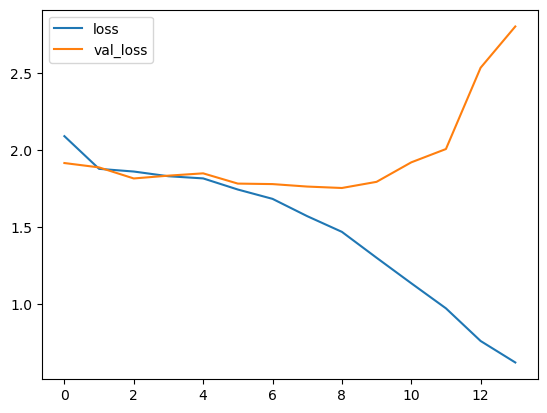

In [195]:
df_hist[["loss","val_loss"]].plot()


<AxesSubplot: >

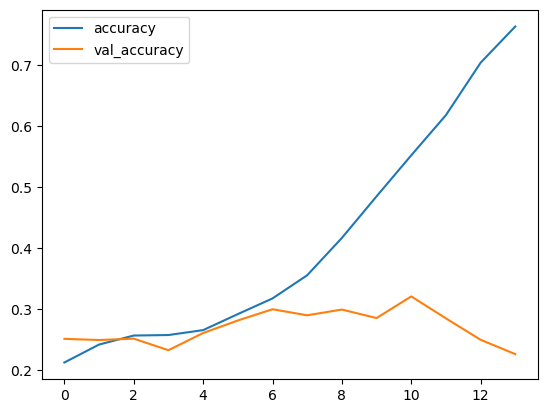

In [196]:
df_hist[["accuracy","val_accuracy"]].plot()


### 모델 예측

In [208]:
pred = model.predict(x_test)

  1/225 [..............................] - ETA: 1:00

2023-03-06 20:35:55.829727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


225/225 [==============================] - 7s 28ms/step


In [209]:
pred[:5]

array([[3.09587419e-01, 4.32634173e-04, 5.97219884e-01, 3.12455017e-02,
        1.90160601e-04, 3.91225256e-02, 2.22019833e-02],
       [3.18209767e-01, 8.53660094e-05, 1.13035426e-01, 1.78800136e-01,
        5.54498062e-02, 3.34322363e-01, 9.71946938e-05],
       [6.70279086e-01, 8.07291921e-03, 2.00241297e-01, 6.04350958e-03,
        7.21629767e-05, 1.11294702e-01, 3.99647700e-03],
       [4.93532538e-01, 1.56373647e-03, 3.28103036e-01, 4.51293914e-03,
        7.39656249e-03, 1.63682222e-01, 1.20895903e-03],
       [1.87405925e-02, 1.85691973e-03, 5.87877147e-02, 8.57976675e-01,
        3.29217277e-02, 1.76456794e-02, 1.20707070e-02]], dtype=float32)

In [210]:
predict = np.argmax(pred, axis = 1)
predict[:5]

array([2, 5, 0, 0, 3])

### 예측값 체점

In [211]:
category = {'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [212]:
answer = []
for i in y_test_img:
    answer.append(category[i])
answer[:5]

[3, 3, 3, 3, 3]

In [213]:
answer = np.array(answer)

In [214]:
predict[:5]

array([2, 5, 0, 0, 3])

In [215]:
(answer == predict).mean()

0.23293396489272777